# <center> Hot Jupiter formation in the TESS era </center>

Some quick definitions and background.

$\textbf{Hot Jupiters (HJs)}$: Jupiter sized planets that orbit very close to their host stars (orbital periods $\sim$few days). We think these objects originally formed much further out (beyond a few AU) and migrated to their current positions. There are two well studied pathways for this: $\textit{disk migration}$ and $\textit{eccentric migration}$. I'll spare you the physics details. The important part here is that very simple versions of these theories make strong predictions regarding where HJs should ultimately end up in regards to their $\textit{Roche separation}, a_{Roche}$. Disk migration says HJs should only be found at semi-major axes ($a$) greater than the Roche separation ($x\equiv a/a_{Roche}> 1$). Eccentric migration says HJs should be at $x>2$. Of the $\sim$200 HJs discovered to date, most have $x>2$, but roughly 10 have $1<x<2$.

$\textbf{TESS}$: TESS is a space telescope that will monitor the entire sky to search for planets orbiting nearby bright stars. It's expected to find on the order of $\textbf{10,000}$ HJs. This is orders of magnitude larger than the current sample.
- Why is this good: More data allows us to do more detailed modeling, e.g., move beyond basic assumptions of disk/eccentric migration and possibly infer new physics behind Hot Jupiter formation.
- Why is this bad: Most planets won't have mass measurements and Jupiter sized planets range from 0.2-14 Jupiter masses. So we have to model 10,000+ unknown masses that span a couple orders of magnitude. It sounded daunting at first, but it turns out that $x$ scales somewhat weakly with mass ($x \propto \text{mass}^{1/3}$). So maybe this is tractable.

$\textbf{Science Motivation}$: What details on HJ formation can be extracted from the TESS data?

Can a $\textit{mixture of populations}$ consistent with these two formation theories be inferred from this large dataset, even with no knowledge of planet masses? If so, could we place meaningful constraints on the prevalence of each mechanism (i.e, mixture fraction)? If not, how many planets would we have to measure masses for before we could do this?

$\textbf{Status right now}$: I'm viewing this problem through hierarchical Bayesian framework.

I'm generating hundreds of synthetic datasets and I want to see if I can recover the input properties of my generative model (a mixture of two truncated power-laws with lower truncations at $x=1$ and $x=2$). I'm looking at a wide range of power-law indices ($\gamma$), the mixture fractions ($\theta$), and the sample sizes.

I'm using Stan to sample from this high-dimensional space. It works well for hundreds of planets, but I'm trying to find efficient ways to sample from 1000+ dimensional models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan # need to install through, e.g., pip (pip install pystan)
import getData # Python file in this directory
import generate # Python file in this directory
import sys
import re
%matplotlib inline

## <center> My Stan models </center>

Let's consider two models.

The first one assumes I know the masses of all the planets.

The second one does not.

My population-level parameters include the mixture fraction ($\theta$), power-law indices ($\gamma$), lower truncation locations for each power-law ($x_l$), and the shared upper truncation for both power-laws ($x_u$).

In [2]:
model_withmasses = '''
data {
    int<lower=1> K; // number of mixture components
    int<lower=0> N; // number of planets
    real x[N]; // per values for N planets
}
parameters {
    simplex[K] theta; // mixing proportions
    real gamma[K]; // power-law indices
    real xl[K]; // xlower
    real xu; // xupper
}
model {
    real ps[K];
    real xlower[K];
    real xupper[K];
    real integral[K];
        
    xlower[1] <- xl[1]; // xl for first component
    xlower[2] <- xl[2]; // xl for second component
    xupper[1] <- xu; // xu for first component
    xupper[2] <- xu; // xu for second component

    gamma ~ uniform(-20.,20.); // prior on gamma
    xl ~ uniform(0., 40.);
    xu ~ uniform(xl[2], 40.); // prior on xu

    integral[1] <- (xupper[1]^(gamma[1]) - xlower[1]^(gamma[1]))/gamma[1];
    integral[2] <- (xupper[2]^(gamma[2]) - xlower[2]^(gamma[2]))/gamma[2];

    for (n in 1:N) { //loop over planets
        for (k in 1:K){
            if ((x[n] > xlower[k]) && (x[n] < xupper[k]))
            {
                ps[k] <- theta[k] * (x[n])^(gamma[k]-1.)/integral[k];
            }
            else
            {
                ps[k] <- 0.;
            }
        }     
        increment_log_prob( log(sum(ps)) );
    }
} '''

In [3]:
model_nomasses = '''
data {
    int<lower=1> K; // number of mixture components
    int<lower=0> N; // number of planets
    real per[N]; // per values for N planets
    real rad[N]; // rad values for N planets
}
parameters {
    simplex[K] theta; // mixing proportions
    real gamma[K]; // power-law indices
    real xl[K]; // xlower
    real xu; // xupper
    real<lower=-0.69897,upper=1.14612803568> log_mass[N]; // 0.2 < Jupiter masses < 14
}
transformed parameters{
    real mass[N];

    for (n in 1:N)
    {
        mass[n] <- 10. ^ log_mass[n];
    }
}
model {
    real ps[K];
    real xlower[K];
    real xupper[K];
    real integral[K];
    
    real RJtoAU;
    real MJtoMsun;
    
    real x[N];
    
    xlower[1] <- xl[1]; // xl for first component
    xlower[2] <- xl[2]; // xl for second component
    xupper[1] <- xu; // xu for first component
    xupper[2] <- xu; // xu for second component

    RJtoAU <- 0.000477894503;
    MJtoMsun <- 0.000954265748;
    
    gamma ~ uniform(-20.,20.); // prior on gamma
    xl ~ uniform(0., 40.);
    xu ~ uniform(xl[2], 40.); // prior on xu
    log_mass ~ uniform(-0.69897, 1.14612803568); 

    integral[1] <- (xupper[1]^(gamma[1]) - xlower[1]^(gamma[1]))/gamma[1];
    integral[2] <- (xupper[2]^(gamma[2]) - xlower[2]^(gamma[2]))/gamma[2];

    for (n in 1:N) { //loop over planets
        x[n] <- 0.462 * (per[n]/365.242)^(0.66667) * (mass[n] * MJtoMsun)^(0.3333) / ( rad[n] * RJtoAU );

        for (k in 1:K){
            if ((x[n] > xlower[k]) && (x[n] < xupper[k]))
            {
                ps[k] <- theta[k] * (x[n])^(gamma[k]-1.)/integral[k];
            }
            else
            {
                ps[k] <- 0.;
            }
        }     
        increment_log_prob( log(sum(ps)) );
    }
} '''

Here is a dataset with roughly 500 planets (499 to be exact, but it doesn't really matter). The generative model used $\gamma_1=-2.5$, $\gamma_2=-3.5$, and $\theta_1 (\theta_2)=0.8 (0.2)$. I chose relatively steep power-laws since I thought we could more easily distinguish these two overlapping populations. From left to right, data are planet orbital period (days), mass (Jupiter masses), radius (Jupiter radii), and x.

In [4]:
filename = "gd=-2.5_ge=-3.5_f=0.8_n=500.in"

Assuming we know all the HJ masses, there's no individual parameters to marginalize over. So I'm just sampling from the population-level parameters. This should run in a couple minutes.

In [5]:
nChains = 1
nIterations = 10000
nThin = 5
nJobs = 1

data = getData.create_dict_from_file(filename)
Stan_data = { 'N': len(data['rad']), 'K': 2, 'x': data['x'] }

g1, g2, f, num = tuple(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", filename)))
f1 = abs(f-0.01)

Stan_ICs = generate.ICs_2comp_withmasses([[f1, 1.-f1], [g1, g2], [1., 2.], 30.], nChains)

fit_withmasses = pystan.stan(model_code=model_withmasses, data=Stan_data, \
                  iter=nIterations, chains=nChains, thin=nThin, init=Stan_ICs, n_jobs=nJobs)

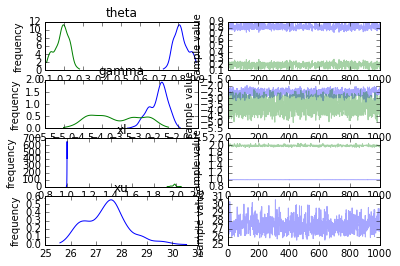

In [6]:
fit_withmasses.plot();

Now let's assume we don't know anything about the masses but initialize unknown masses near their "true" values.

In [7]:
nChains = 1
nIterations = 20000
nThin = 10
nJobs = 1

data = getData.create_dict_from_file(filename)
Stan_data = { 'N': len(data['rad']), 'K': 2, 'rad': data['rad'], 'per': data['per'] }

g1, g2, f, num = tuple(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", filename)))
f1 = abs(f-0.01)

Stan_ICs = generate.ICs_2comp_nomasses([[f1, 1.-f1], [g1, g2], [1., 2.], 30.], np.log10(data['mass']), nChains)
    
fit_nomasses = pystan.stan(model_code=model_nomasses, data=Stan_data, \
                  iter=nIterations, chains=nChains, thin=nThin, init=Stan_ICs, n_jobs=nJobs)

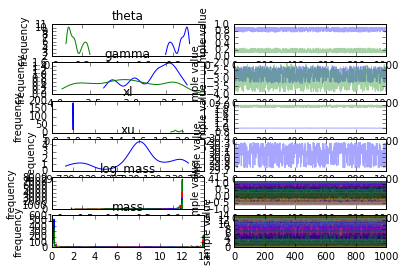

In [8]:
fit_nomasses.plot();

Now let's consider the same generative model but a dataset containing roughly 5000 planets.

This part is pretty hard. I can't really get it to converge to the correct solution.

In [9]:
filename_hard = "gd=-2.5_ge=-3.5_f=0.8_n=5000.in"

In [10]:
nChains = 1
nIterations = 20000
nThin = 10
nJobs = 1

data = getData.create_dict_from_file(filename_hard)
Stan_data = { 'N': len(data['rad']), 'K': 2, 'rad': data['rad'], 'per': data['per'] }

g1, g2, f, num = tuple(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", filename_hard)))
f1 = abs(f-0.01)

Stan_ICs = generate.ICs_2comp_nomasses([[f1, 1.-f1], [g1, g2], [1., 2.], 30.], np.log10(data['mass']), nChains)
    
fit_hard = pystan.stan(model_code=model_nomasses, data=Stan_data, \
                  iter=nIterations, chains=nChains, thin=nThin, init=Stan_ICs, n_jobs=nJobs)

postSamp = getData.stan_output_to_posterior_samples_2comp(fit_hard.extract())

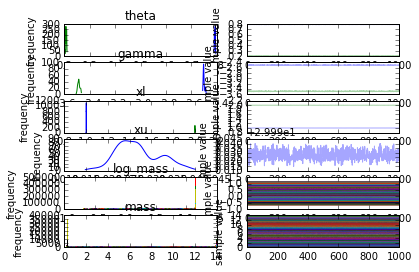

In [11]:
fit_hard.plot();